# Clase 5

### Introducción a Transformers

En este veremos una introducción práctica al uso de transformers para tareas multimodales, específicamente Visual Question Answering (VQA). Integra técnicas de visión por computadora y procesamiento del lenguaje natural para responder preguntas sobre imágenes. Incluye la descarga y manejo de un dataset de VQA, el uso del modelo BLIP para generar respuestas y funciones auxiliares para cargar, procesar imágenes y visualizar resultados.

In [ ]:
# trasnformes
!pip install transformers huggingface-hub
!pip install datasets
!pip install --upgrade datasets
!pip install --upgrade transformers

# librerias extras
!pip install pillow matplotlib requests
!pip install --upgrade Pillow

# evitar warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="transformers.generation.utils")
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Dataset VQA

¿Qué es Visual Question Answering (VQA)?

VQA es una tarea que combina visión por computadora y NLP para responder preguntas basadas en el contenido de una imagen. Ejemplos comunes incluyen:
- "¿Qué objeto se encuentra en la imagen?"
- "¿Qué texto aparece en el letrero?"

In [ ]:
import gdown
#https://drive.google.com/file/d/17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf/view?usp=sharing
#TextVQA_0.5.1_train.json

#TextVQA_0.5.1_test.json
#https://drive.google.com/file/d/1LmrYyUsyLmcswQGHbP9bcF7744l_IiL_/view?usp=sharing

print("Descargando dataset...")
url = 'https://drive.google.com/uc?export=download&id=17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf'
destination = "TextVQA_0.5.1_train.json"
gdown.download(url, destination, quiet=False)

Descargando dataset...


Downloading...
From: https://drive.google.com/uc?export=download&id=17C0RkHlUG3Ymn8SK3bBupC7NqvN1eGqf
To: /content/TextVQA_0.5.1_train.json
100%|██████████| 21.6M/21.6M [00:00<00:00, 41.6MB/s]


'TextVQA_0.5.1_train.json'

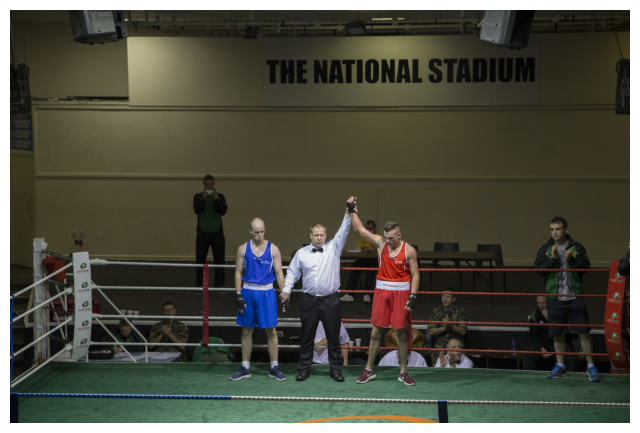

Pregunta: where is this?
Respuestas posibles: ['the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium', 'the national stadium']
Respuesta final más probable: the national stadium


In [ ]:
#@title Exploramos el dataset "TextVQA"

import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from transformers import BlipProcessor, BlipForQuestionAnswering
from io import BytesIO
import time


def cargar_dataset(ruta_json):
    with open(ruta_json, 'r') as f:
        data = json.load(f)
    return data['data']

# Función para obtener un ejemplo aleatorio
def obtener_ejemplo_aleatorio(dataset,ruta_imagenes):
    while True:
        ejemplo = random.choice(dataset)
        img, image_path = obtener_imagen(ejemplo, ruta_imagenes)
        if img is not None:
            return ejemplo, img, image_path
        else:
            print("Intentando con otro ejemplo debido a imagen no disponible.")

def verificar_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

# Función para obtener la imagen
# Función para obtener la imagen
def obtener_imagen(ejemplo, ruta_imagenes):
    verificar_directorio(ruta_imagenes)
    image_id = ejemplo['image_id']
    image_path = os.path.join(ruta_imagenes, f"{image_id}.jpg")

    try:
        if os.path.exists(image_path):
            img = Image.open(image_path).convert('RGB')
        else:
            response = requests.get(ejemplo['flickr_original_url'], timeout=20)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img.save(image_path)
            else:
                print(f"No se pudo descargar la imagen desde {ejemplo['flickr_original_url']}. Código de estado: {response.status_code}")
                return None, None
        return img, image_path
    except requests.exceptions.RequestException as e:
        print(f"Error de red al descargar la imagen: {e}")
        return None, None
    except Image.UnidentifiedImageError:
        print(f"Error: La imagen descargada no es válida.")
        return None, None
    except Exception as e:
        print(f"Error general al procesar la imagen: {e}")
        return None, None

def calcular_respuesta_mas_frecuente(ejemplo):
    respuestas_posibles = ejemplo.get('answers', [])
    if respuestas_posibles:
        respuesta_final = Counter(respuestas_posibles).most_common(1)[0][0]
    else:
        respuesta_final = "No hay respuestas disponibles"
    return respuesta_final

def mostrar_ejemplo(ejemplo, img):
    if img is not None:
        # Mostrar la imagen
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    else:
        print("Imagen no disponible.")

    # Mostrar la pregunta y la respuesta más frecuente
    respuestas_posibles = ejemplo.get('answers', [])
    respuesta_final = calcular_respuesta_mas_frecuente(ejemplo)
    pregunta = ejemplo['question']

    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuestas posibles: {respuestas_posibles}")
    print(f"Respuesta final más probable: {respuesta_final}")
    return pregunta, respuesta_final


def ejecutar_ejemplo():

    # Cargar el dataset
    dataset = cargar_dataset(ruta_json)

    # Obtener un ejemplo aleatorio con imagen disponible
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset,ruta_imagenes)

    # Mostrar el ejemplo
    mostrar_ejemplo(ejemplo, img)

    return ejemplo, img

if __name__ == "__main__":
    ruta_json = '/content/TextVQA_0.5.1_train.json'
    ruta_imagenes = '/content/TextVQA/train_images'
    ejemplo, img = ejecutar_ejemplo()


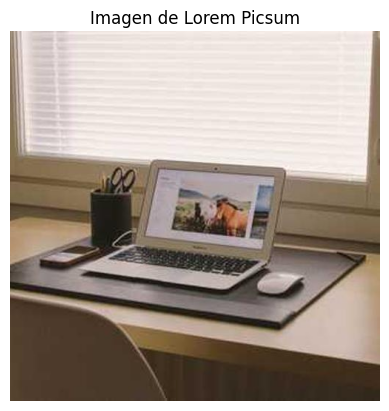

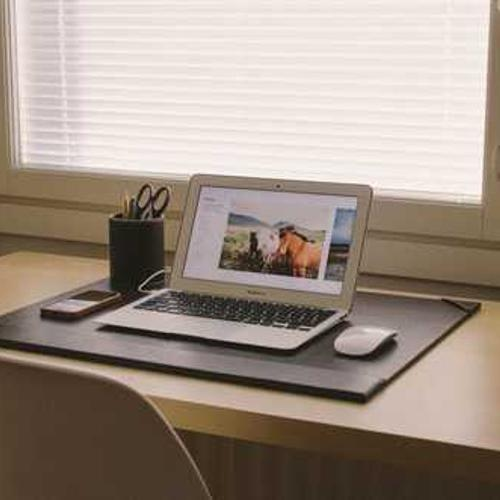

In [ ]:
# Esta funcion obtine una imagen aleatoria del repo: picsum
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

def ejemplo_picsum():
  # URL de una imagen aleatoria de Lorem Picsum
  url = "https://picsum.photos/500/500"
  response = requests.get(url)

  # Verificar si la descarga fue exitosa
  if response.status_code == 200:
      image = Image.open(BytesIO(response.content)).convert('RGB')  # Convertir a RGB para evitar errores

      # Mostrar la imagen usando Matplotlib
      plt.imshow(image)
      plt.axis('off')  # Ocultar los ejes
      plt.title("Imagen de Lorem Picsum")
      plt.show()
      return image
  else:
      raise ValueError(f"Error al descargar la imagen: {response.status_code}")
      return None

ejemplo_picsum()

# 1) Aplicar modelos image-captioning

Permiten obtener la descripcion dada una imagen

In [ ]:
#@title TODO 1: Inferencia de descripciones usando imagenes

### TODO 1: Obtener una imagen del dataset con el metodo "obtener_ejemplo_aleatorio(dataset,ruta_imagenes)"
# el pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
# Mostrar descripcion creada por el modelo
# ¿Le parece acertada la descripcion creada?

# 2) Modelos BLIP

Permiten obtener la descripcion dada una imagen y un texto


### ¿Qué es el modelo BLIP?

BLIP (Bootstrapped Language-Image Pre-training) es un modelo avanzado de **visión-lenguaje** desarrollado para tareas de razonamiento que combinan texto e imágenes, como **Visual Question Answering (VQA)**, **Image Captioning** y **Image-Text Retrieval**.

### ¿Cómo funciona BLIP?

BLIP combina la **visión** y el **lenguaje** utilizando una arquitectura basada en **Transformers**, que son la base de modelos como BERT y GPT. Los Transformers permiten a BLIP analizar imágenes y texto conjuntamente, aprendiendo representaciones ricas y profundas que comprenden tanto el contenido visual como el textual.

### ¿Por qué es importante?

BLIP es importante porque:
- Puede responder preguntas sobre imágenes (VQA).
- Genera descripciones precisas de imágenes (Captioning).
- Encuentra relaciones entre imágenes y textos, mejorando la búsqueda y clasificación.

### Transformers

BLIP utiliza Transformers tanto para procesar texto (como preguntas o descripciones) como para extraer características de las imágenes. Este enfoque unificado lo hace extremadamente potente para tareas multimodales, donde la combinación de información visual y textual es clave.

### Aplicaciones

- **Medicina**: Analizar imágenes médicas y generar descripciones clínicas.
- **Educación**: Crear herramientas interactivas que combinen texto e imágenes.
- **Seguridad**: Reconocimiento y descripción de escenas.

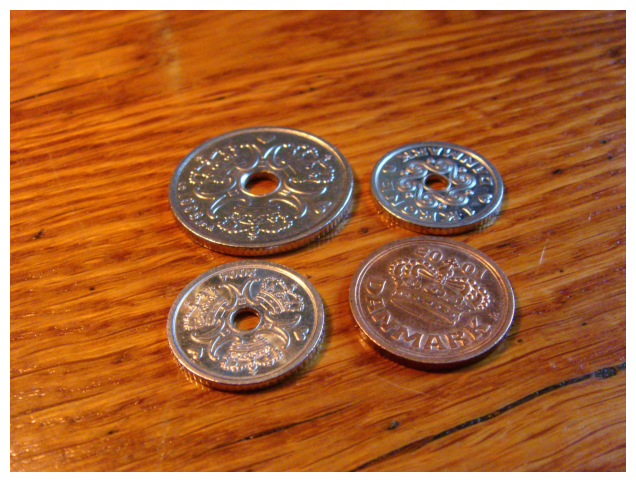

Pregunta: what year is the coin?
Respuestas posibles: ['2001', '2001', '2001', '2001', '2001, 2004 and 1996', '2001', '2001', '2001', '2001', '2001']
Respuesta final más probable: 2001
Cargando el modelo: Salesforce/blip-vqa-base


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]


 Respuesta generada: 2012


In [ ]:
import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForQuestionAnswering
from io import BytesIO

# Cargar modelo
def cargar_modelo(nombre_modelo):
    """
    Carga un modelo y su procesador para responder preguntas sobre imágenes.
    """
    try:
        print(f"Cargando el modelo: {nombre_modelo}")
        # Carga el procesador necesario para preprocesar imágenes y preguntas (tokenización y transformaciones).
        # Carga el modelo preentrenado para responder preguntas basadas en imágenes.
        processor = BlipProcessor.from_pretrained(nombre_modelo)
        model = BlipForQuestionAnswering.from_pretrained(nombre_modelo)
        return processor, model
    except Exception as e:
        print(f"Error al cargar el modelo {nombre_modelo}: {e}")
        return None, None

# Predecir respuestas
def predecir_respuestas(ejemplo, img, processor, model):
    """
    Utiliza el modelo para predecir la respuesta a la pregunta de un ejemplo.
    """
    try:
        inputs = processor(images=img, text=ejemplo['question'], return_tensors="pt")
        output = model.generate(input_ids=inputs['input_ids'], pixel_values=inputs['pixel_values'])
        respuesta_generada = processor.decode(output[0], skip_special_tokens=True)
        print(f"\n Respuesta generada: {respuesta_generada}")
    except Exception as e:
        print(f"Error al predecir la respuesta: {e}")

# Flujo principal
def ejecutar_ejemplo():

    modelo = "Salesforce/blip-vqa-base"

    # Cargar el dataset
    dataset = cargar_dataset(ruta_json)

    # Obtener un ejemplo aleatorio
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset, ruta_imagenes)

    # Mostrar ejemplo
    mostrar_ejemplo(ejemplo, img)

    # Cargar el modelo
    processor, model = cargar_modelo(modelo)

    if processor and model:
        # Predecir respuesta
        predecir_respuestas(ejemplo, img, processor, model)

if __name__ == "__main__":
    ejecutar_ejemplo()


In [ ]:
#@title TODO 2:  Obtener una imagen del dataset con el metodo "obtener_ejemplo_aleatorio(dataset,ruta_imagenes)"
# Usar el modelo "dandelin/vilt-b32-finetuned-vqa"
# ¿Cree que funciona mejor con ese modelo o no ?

In [ ]:
#@title Buscar modelos

from huggingface_hub import list_models

def obtener_modelos_blip_vqa():
    """
    Obtiene una lista de modelos compatibles con BlipProcessor y BlipForQuestionAnswering,
    relacionados con Visual Question Answering (VQA), desde Hugging Face.
    """
    # Palabras clave específicas para filtrar modelos BLIP y VQA
    blip_keywords = ["blip", "visual-question-answering", "vqa", "Salesforce", "Dandelin", "Microsoft"]
    blip_models = set()

    for keyword in blip_keywords:
        models = list(list_models(search=keyword))
        # Filtrar aquellos que contienen 'blip', 'vqa' o nombres relevantes en el ID del modelo
        blip_models.update(model.modelId for model in models
                           if any(term in model.modelId.lower() for term in ["blip", "vqa", "visualbert", "git", "layoutlm", "donut"]))

    return list(blip_models)

# Llamar a la función y mostrar los modelos encontrados
modelos_blip_vqa = obtener_modelos_blip_vqa()
print(f"Modelos compatibles con BlipProcessor y BlipForQuestionAnswering: {len(modelos_blip_vqa)}")
for modelo in modelos_blip_vqa:
    print(modelo)

# tener en cuenta cada uno viene de un repo que tien sus propias configuraciones

Modelos compatibles con BlipProcessor y BlipForQuestionAnswering: 1312
seitzm97/Fine-tuned-BLIB-VQA
shuda5280/blip-checkpoint1-bdd
toilaluan/Florence-2-base-Yes-No-VQA
PepBun/blip2-opt-2.7b-duski_captioner_customtrainer
oclmodels/vqav2_questions
avatarcontinues/blip1000captions
shaden777/ft-ms-git-base-pokemon-blip-captions
arit98/blip2-opt-2.7b-fashion
abhijithgururaj/blip2-opt-2.7b-french-pre-lora-abhijith
VivekChauhan06/Florence-2-OK-VQA
vamsidulam/vqa_graphcore2
datnguyentien204/BLIP_PretrainVietNamese
Vision-Flan/vision-flan_blip2_xl
m-aliabbas1/Florence-2-FT-path-vqa
satefi/fine-tuned-blip2-opt-2.7b-coco-captions-adapters
Covie/paligemma_vqav2
marwanimroz18/blip-trainer
DanielTC/blip2-opt-6.7b-aeroscapes_train-metacaptions-adapters-4-0.37
mavericklsd/paligemma_vqav2
huggingfaceofSAMI/my-blip-model
rbeauchamp/blip_10k_deduped_5epoch_6batch_5e-05lr_AdamW_2e-2wd
jonastokoliu/image_caption_git-base_pokemon-blip-captions_finetune
Hamza12rdsdsf/blip2-opt-2.7b-onepiece-fine-tuned
hyo370

In [ ]:
#Complementario probar con otro modelo que sea compatible

# 3) Modelos OCR

Este código combina procesamiento de imágenes y texto para responder preguntas visuales (vqa). Utiliza ocr y modelos de lenguaje para generar respuestas.

1. **extracción de texto**: usa ocr (tesseract) para obtener texto de imágenes.
2. **generación de respuestas**: emplea modelos de lenguaje (gpt-2) y visión (donut) para responder.
3. **visualización**: muestra la imagen, la pregunta y las respuestas.

### modelos especializado:

-  **donut (ocr-free document understanding transformer)**
  - interpreta documentos directamente desde la imagen, sin necesidad de ocr.
  - ideal para documentos complejos como facturas o recibos.


### Repasando aplicaremos 2 tecnicas
1. Extraeremos texto con OCR, y predeciremos la repuesta, usando la pregunta y el texto extraido, como entrada para el modelo GPT-2

2. Usar donut


In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,107 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,424 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubunt

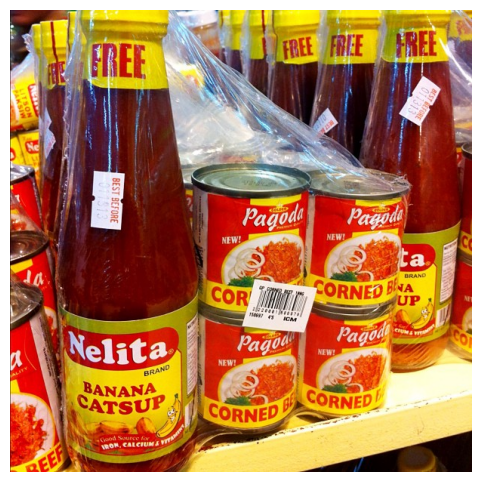

Pregunta: what is the brand on the bottle?
Respuestas posibles: ['nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita', 'nelita']
Respuesta final más probable: nelita

Usando OCR y GPT-2:
No se pudo extraer texto de la imagen.

Usando Donut:


sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    2560,
    1920
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "transformers_version": "4.46.2",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "add

model.safetensors:   0%|          | 0.00/803M [00:00<?, ?B/s]

Respuesta generada por Donut: what is the brand on the bottle? na


In [ ]:
### Obbtenemos descripciones con OCR y donut

import os
import json
import random
import requests
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import pytesseract
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DonutProcessor, VisionEncoderDecoderModel

# Extraer texto de la imagen usando OCR
def extraer_texto(img):
    return pytesseract.image_to_string(img)

# Generar respuesta usando GPT-2
def generar_respuesta_con_gpt2(pregunta, contexto):
    from transformers import GPT2Tokenizer, GPT2LMHeadModel

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2') # recordar LM Head toma espacio latente (tensores) y calcula las probabilidades de cada token en el vocabulario.

    # Codificar la entrada
    entrada = f"Contexto: {contexto}\nPregunta: {pregunta}\nRespuesta:"
    inputs = tokenizer.encode(entrada, return_tensors='pt')

    # Ajustar max_new_tokens en lugar de max_length
    outputs = model.generate(
        inputs,
        max_new_tokens=50,  # Genera hasta 50 tokens adicionales
        pad_token_id=tokenizer.eos_token_id, # es que este modelo tampoco tiene un token de padding nativo
        num_return_sequences=1
    )

    respuesta = tokenizer.decode(outputs[0], skip_special_tokens=True)
    respuesta = respuesta.split("Respuesta:")[-1].strip()
    return respuesta


# Predecir respuesta usando OCR y GPT-2
def predecir_respuesta_con_ocr(ejemplo, img):
    if not img:
        print("Imagen no disponible para OCR.")
        return
    texto = extraer_texto(img)
    if not texto.strip():
        print("No se pudo extraer texto de la imagen.")
        return
    respuesta = generar_respuesta_con_gpt2(ejemplo['question'], texto)
    print(f"Respuesta generada con OCR y GPT-2: {respuesta}")

# Predecir respuesta usando Donut
def predecir_respuesta_con_donut(ejemplo, img):
    # Verifica si la imagen está disponible
    if not img:
        print("Imagen no disponible para Donut.")
        return  # Si no hay imagen, termina la función

    # Determina si usar GPU ('cuda') o CPU para ejecutar el modelo
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Carga el procesador Donut (encargado de preparar las entradas) preentrenado para DocVQA
    processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

    # Carga el modelo Donut VisionEncoderDecoder ya ajustado para DocVQA
    model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa").to(device)

    # Procesa la imagen: convierte la imagen en tensores adecuados para el modelo
    pixel_values = processor(img, return_tensors="pt").pixel_values.to(device)

    # Crea el prompt de entrada para el modelo, que incluye la pregunta
    # El modelo Donut utiliza un formato específico con etiquetas especiales (<s_docvqa>, <s_question>, etc.)
    prompt = f"<s_docvqa><s_question>{ejemplo['question']}</s_question><s_answer>"

    # Tokeniza el prompt para obtener su representación en forma de tensores
    input_ids = processor.tokenizer(
        prompt,
        add_special_tokens=False,  # No se añaden tokens especiales adicionales
        return_tensors="pt"        # Devuelve tensores listos para ser procesados por el modelo
    ).input_ids.to(device)

    # Genera una respuesta usando el modelo. La salida se detiene cuando alcanza el max_length o genera un token de parada.
    outputs = model.generate(
        pixel_values,            # Tensores de la imagen
        decoder_input_ids=input_ids,  # Prompt tokenizado
        max_length=256           # Longitud máxima de la respuesta generada
    )

    # Decodifica la salida del modelo a texto legible
    respuesta = processor.batch_decode(outputs, skip_special_tokens=True)[0]

    # Limpia la respuesta generada: remueve etiquetas especiales como <s_docvqa>
    respuesta = respuesta.replace('<s_docvqa>', '').strip()

    # Muestra la respuesta final generada por Donut
    print(f"Respuesta generada por Donut: {respuesta}")

# Flujo principal
def ejecutar_ejemplo():
    dataset = cargar_dataset(ruta_json)
    ejemplo, img, image_path = obtener_ejemplo_aleatorio(dataset, ruta_imagenes)
    mostrar_ejemplo(ejemplo, img)

    print("\nUsando OCR y GPT-2:")
    predecir_respuesta_con_ocr(ejemplo, img)

    print("\nUsando Donut:")
    predecir_respuesta_con_donut(ejemplo, img)

if __name__ == "__main__":
    ejecutar_ejemplo()


# 4) Modelos de generación de texto

### Hiperparámetros comunes en la generación de texto


### **1. Longitud máxima (max_length)**
- **¿Qué es?**: Especifica cuántos tokens puede tener como máximo el texto generado, incluyendo los tokens iniciales.
- **Impacto**: Limita la extensión del texto. Si se alcanza este valor, el modelo detendrá la generación.
- **Útil para**: Evitar respuestas demasiado largas o cortar texto innecesario.



### **2. Muestreo aleatorio (do_sample)**
- **¿Qué es?**: Permite introducir aleatoriedad en la generación de texto, en lugar de elegir siempre el token más probable.
- **Impacto**: Hace que las respuestas sean más diversas y creativas.
- **Útil para**: Escenarios donde la variedad es importante, como la escritura creativa.



### **3. Número de opciones más probables (top_k)**
- **¿Qué es?**: Limita la elección del siguiente token a los `k` tokens más probables.
- **Impacto**: Reduce la probabilidad de generar texto incoherente, pero mantiene cierta diversidad.
- **Útil para**: Balancear entre coherencia y creatividad.


### **4. Control de creatividad (temperature)**
- **¿Qué es?**: Ajusta la aleatoriedad en la selección de tokens. Valores más bajos generan texto más conservador, mientras que valores más altos promueven la creatividad.
- **Impacto**:
  - **Baja temperatura (e.g., 0.2)**: Texto más predecible y seguro.
  - **Alta temperatura (e.g., 1.0)**: Texto más variado y creativo.
- **Útil para**: Ajustar el tono y estilo del texto según el contexto.


### **5. Token de relleno (pad_token_id)**
- **¿Qué es?**: Un token especial utilizado para alinear secuencias de diferentes longitudes en un lote (*batch*).
- **Impacto**: No afecta directamente al texto generado, pero es crucial para que el modelo procese correctamente los datos en lotes.
- **Útil para**: Procesamiento eficiente de múltiples secuencias en paralelo.


### **Hiperparámetros adicionales**

#### **Número de caminos simultáneos (num_beams)**
- **¿Qué es?**: Indica cuántas alternativas simultáneas considera el modelo durante la generación de texto.
- **Impacto**: Mejora la calidad del texto a costa de mayor tiempo de procesamiento.
- **Útil para**: Escenarios donde la calidad es más importante que la rapidez.

#### **Detención temprana (early_stopping)**
- **¿Qué es?**: Finaliza la generación de texto cuando se alcanza un token específico de finalización.
- **Impacto**: Evita que el modelo genere texto más allá de lo necesario.
- **Útil para**: Respuestas precisas y controladas.

#### **Penalización por repetición (repetition_penalty)**
- **¿Qué es?**: Penaliza la repetición de palabras o frases para evitar redundancias.
- **Impacto**: Mejora la fluidez del texto.
- **Útil para**: Textos más variados y naturales.


In [ ]:
#@title Ejemplo generamos texto con una pregunta y repuesta

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Cargar el modelo y el tokenizador
modelo_es = "EleutherAI/gpt-neo-1.3B"  # Modelo autoregresivo para generación de texto
tokenizer_es = AutoTokenizer.from_pretrained(modelo_es)
modelo_generador_es = AutoModelForCausalLM.from_pretrained(modelo_es).to("cuda" if torch.cuda.is_available() else "cpu")

def generar_descripcion_larga(pregunta, respuesta):
    """
    Genera una descripción larga en español basada en la pregunta y la respuesta proporcionadas.
    """
    # Crear el prompt en español
    prompt = (f"Basado en la pregunta '{pregunta}' y la respuesta '{respuesta}', "
              f"genera una descripción detallada del contexto relacionado con la imagen:")

    # Tokenizar el prompt
    inputs = tokenizer_es(prompt, return_tensors="pt").to(modelo_generador_es.device)

    # Generar el texto
    outputs = modelo_generador_es.generate(
        inputs.input_ids,
        max_length=300,  # Longitud máxima
        do_sample=True,
        top_k=50,
        temperature=0.7,
        pad_token_id=tokenizer_es.eos_token_id
    )

    # Decodificar el texto generado
    descripcion_generada = tokenizer_es.decode(outputs[0], skip_special_tokens=True)
    return descripcion_generada

# Ejemplo de uso
pregunta_es = "¿Qué producto se anuncia en la cartelera?"
respuesta_es = "Coca Cola"

descripcion = generar_descripcion_larga(pregunta_es, respuesta_es)
print("\nDescripción generada:\n", descripcion)


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]


Descripción generada:
 Basado en la pregunta '¿Qué producto se anuncia en la cartelera?' y la respuesta 'Coca Cola', genera una descripción detallada del contexto relacionado con la imagen:

La carta que el presidente de la República puso a la venta en el año 2000 presenta una imagen de su propio país, que ha ido desapareciendo en la historia. La carta está inspirada en el país de César Chávez, quien, en su forma de vida había perdido la vida a los seres humanos, y estaba destinado a la venta en el año 2000:

"Estoy muy preocupado por lo que pueda pasarle a la gente de Cuba en el futuro. El país se ha transformado en una nación desconocida, sin idea de la libertad de expresión y de acción, la impunidad y la violencia, y el país perdió la capacidad de expresión de la humanidad.

El país se ha convertido en una nación que no sabía qué hacer y está intentando hacer algo.


In [ ]:
### TODO 3: Usar el dataset "TextVQA", extraer 10 registros
### Usando la pregunta y repuesta, de los registros extraido, creae un nuevo texto con el modelo_es = "EleutherAI/gpt-neo-1.3B"

In [ ]:
### Opcional: cambia el codigo anterior y utiliza alguno de los siguientes modelos
#modelo_es = "datificate/gpt2-small-spanish"  # GPT-2 ajustado al español
#modelo_es = "LenguajeNaturalAI/leniachat-gemma-2b-v0"  # Chatbot avanzado en español
#modelo_es = "QuantFactory/leniachat-gemma-2b-v0-GGUF"  # Optimizado para chat en español
#modelo_es = "Nichonauta/pepita-2-2b-it-v1-Q4_0-GGUF"  # Optimizado para hardware con recursos limitados
#modelo_es = "PlanTL-GOB-ES/roberta-base-bne"  # Entrenado en el corpus BNE español
#modelo_es = "mrm8488/spanish-gpt2"  # GPT-2 ajustado en español
#modelo_es = "HuggingFace/CodeParrot"  # Generador de código adaptable a español

### ¿Los modelos estan disponibles? ¿Que modelo le parece el más eficiente?

### Creamos un sample del dataset original

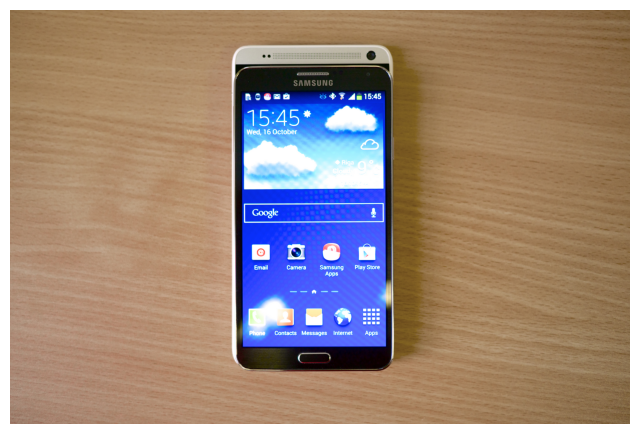

Pregunta: what is the date on this phone?
Respuestas posibles: ['16 october', '16 october', '16 october', 'google', 'october 16', 'wed. 16 october', 'no', '10/16', 'october 16', 'wed 16 october']
Respuesta final más probable: 16 october


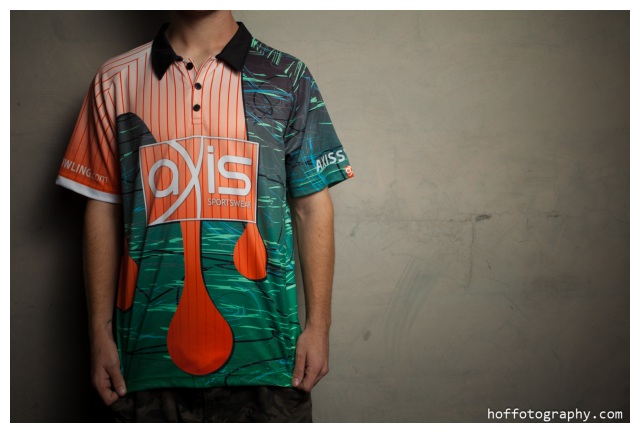

Pregunta: is he wearing something related to sports?
Respuestas posibles: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
Respuesta final más probable: yes


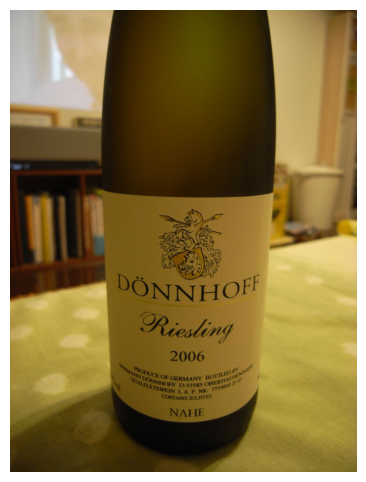

Pregunta: what year is this bottle from?
Respuestas posibles: ['2006', '2006', '30', '2006', '2006', '2006', '2006', '2006', '2006', '2006']
Respuesta final más probable: 2006


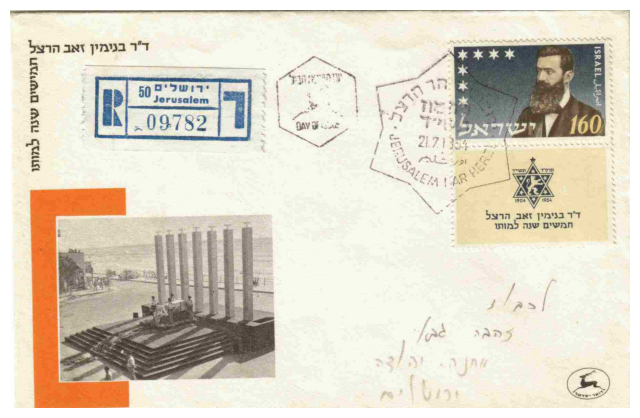

Pregunta: 160 postage stamp?
Respuestas posibles: ['yes', 'yes', 'not a question', 'yes', 'yes', 'yes', 'yes', 'not a question', 'not a question', 'ye']
Respuesta final más probable: yes


In [ ]:
import os
import json
from PIL import Image
import random
import matplotlib.pyplot as plt

def descargar_imagenes_y_crear_dataset(num_imagenes=4, ruta_dataset="dataset_vqa", cargar_funciones=None):
    """
    Crea un dataset utilizando funciones externas para cargar imágenes y generar preguntas y respuestas.
    """
    if not cargar_funciones:
        raise ValueError("Se deben proporcionar las funciones cargar_dataset, obtener_ejemplo_aleatorio y mostrar_ejemplo.")

    cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo = cargar_funciones

    dataset = []
    #ruta_json = os.path.join(ruta_dataset, "dataset.json")

    if not os.path.exists(ruta_dataset):
        os.makedirs(ruta_dataset)

    for i in range(num_imagenes):
        ejemplo, img, image_path = obtener_ejemplo_aleatorio(cargar_dataset(ruta_json), ruta_dataset)
        pregunta, respuesta = mostrar_ejemplo(ejemplo, img)
        # aqui estan la pregunta y respuesta en ingles

        dataset.append({
            "image_path": image_path,
            "question": pregunta,
            "answer": respuesta
        })

    # Guardar el dataset en formato JSON
    with open(ruta_json, "w") as json_file:
        json.dump({"data": dataset}, json_file, indent=4)

    return dataset

# Ejecución
ruta_dataset = "dataset_vqa_en"
funciones_cargar = (cargar_dataset, obtener_ejemplo_aleatorio, mostrar_ejemplo)

dataset_en = descargar_imagenes_y_crear_dataset(
    num_imagenes=4,
    ruta_dataset=ruta_dataset,
    cargar_funciones=funciones_cargar
)


In [ ]:
print(dataset_en)

[{'image_path': 'dataset_vqa_en/120b3cbd2dcff6eb.jpg', 'question': 'what is the date on this phone?', 'answer': '16 october'}, {'image_path': 'dataset_vqa_en/7035f9ed3ac7f0d5.jpg', 'question': 'is he wearing something related to sports?', 'answer': 'yes'}, {'image_path': 'dataset_vqa_en/24495eadde5b3810.jpg', 'question': 'what year is this bottle from?', 'answer': '2006'}, {'image_path': 'dataset_vqa_en/0ea34c96d1440d6e.jpg', 'question': '160 postage stamp?', 'answer': 'yes'}]


In [ ]:
### TODO 4: Crea un dataset "dataset_vqa_es"
# Traduce cada pregunta y repuesta al español usando ("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es")
# Carga al menos 30 registros
# puede usar descargar_imagenes_y_crear_dataset(num_imagenes=4, ruta_dataset="dataset_vqa", cargar_funciones=None) u otra funcion que cocnsidera adecuada


# 5) Fine-tuning del modelo BLIP para Visual Question Answering

En este proyecto realizaremos un **fine-tuning** del modelo **BLIP (Bootstrapped Language-Image Pre-training)**, específicamente para la tarea de **Visual Question Answering (VQA)**. Esto implica entrenar el modelo en un conjunto personalizado de datos, donde cada muestra consta de una imagen, una pregunta sobre esa imagen, y una respuesta asociada.

### Pasos principales:

1. **Creación del dataset**:
   Se utilizan imágenes aleatorias junto con preguntas y respuestas generadas manualmente. Este dataset personalizado servirá para entrenar y validar el modelo.

2. **Carga del modelo BLIP**:
   BLIP combina información visual (de las imágenes) y textual (de las preguntas) para generar respuestas. Utilizaremos su capacidad para aprender a responder preguntas específicas basadas en nuestro dataset.

3. **Entrenamiento y validación**:
   El modelo se entrena en las imágenes y preguntas del dataset, ajustando sus parámetros para minimizar el error en las respuestas generadas. Luego, se valida su desempeño en un conjunto separado de datos.

4. **Evaluación**:
   Después del entrenamiento, se evalúa el modelo con ejemplos nuevos, observando cómo genera respuestas basadas en imágenes nunca vistas durante el entrenamiento.

### Beneficios de este proceso:

- **Adaptación a tareas específicas**: El modelo aprende a resolver problemas específicos, como responder preguntas particulares sobre un tipo de imágenes.
- **Eficiencia**: Al partir de un modelo preentrenado, se requiere menos tiempo y datos para lograr buenos resultados.
- **Aplicaciones personalizadas**: Este enfoque puede aplicarse en áreas como medicina, educación y automatización de procesos documentales.


Epoch 1/3
Train Loss: 11.1483, Validation Loss: 10.3091
Epoch 2/3
Train Loss: 10.3076, Validation Loss: 10.2908
Epoch 3/3
Train Loss: 10.2941, Validation Loss: 10.2811
Pregunta: is the object round?
Respuesta esperada: yes
Respuesta generada: yes


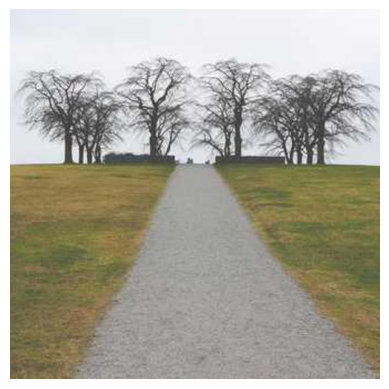

In [ ]:
### Ejemplo fine-tunning (imagenes Lorem picsum, preguntas y repuestas)

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import random
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os

# Definir el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear una carpeta para guardar las imágenes si no existe
os.makedirs('dataset_vqa_test', exist_ok=True)

# Descargar 4 imágenes aleatorias de picsum.photos y guardarlas
for i in range(4):
    response = requests.get(f"https://picsum.photos/500/500?random={i}")
    with open(f"dataset_vqa_test/image_{i}.jpg", 'wb') as f:
        f.write(response.content)

# Crearmos un dataset hardcodeado con preguntas y respuestas al azar
dataset_personalizado = [
    {'image_path': 'dataset_vqa_test/image_0.jpg', 'question': 'what is the color of the sky?', 'answer': 'blue'},
    {'image_path': 'dataset_vqa_test/image_1.jpg', 'question': 'how many people are there?', 'answer': 'three'},
    {'image_path': 'dataset_vqa_test/image_2.jpg', 'question': 'what is the object in the center?', 'answer': 'tree'},
    {'image_path': 'dataset_vqa_test/image_3.jpg', 'question': 'is the object round?', 'answer': 'yes'}
]

# Clase de Dataset personalizado
class VQADataset(Dataset):
    """
    Dataset personalizado para Visual Question Answering.
    """
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        # Procesar imagen y pregunta
        encoding = self.processor(images=image, text=item['question'], padding='max_length', truncation=True, return_tensors="pt")
        # Tokenizar la respuesta para obtener las etiquetas
        labels = self.processor.tokenizer(item['answer'], padding='max_length', truncation=True, return_tensors="pt").input_ids
        # Asegurarse de que los tensores tengan la dimensión correcta
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        labels = labels.squeeze()
        encoding['labels'] = labels
        #print(encoding['attention_mask'])  # Verifica que se genere correctamente
        #print(inputs['attention_mask'].shape)  # Verificar que la máscara se esté usando
        return encoding

# Asegurarse de que hay suficientes datos para entrenamiento y validación
if len(dataset_personalizado) < 2:
    print("Necesitas al menos 2 datos para dividir en entrenamiento y validación.")
else:
    # Dividir dataset en entrenamiento y validación
    random.shuffle(dataset_personalizado)
    division = int(0.8 * len(dataset_personalizado))
    train_data = dataset_personalizado[:division]
    val_data = dataset_personalizado[division:]

    # Cargar modelo y procesador BLIP
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

    # Crear DataLoaders
    train_dataset = VQADataset(train_data, processor)
    val_dataset = VQADataset(val_data, processor)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=2)

    # Configuración del optimizador y entrenamiento
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    def train_epoch(model, dataloader, optimizer):
        """
        Entrena el modelo por una época.
        """
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def eval_epoch(model, dataloader):
        """
        Evalúa el modelo en el dataset de validación.
        """
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs, labels=labels)
                total_loss += outputs.loss.item()
        return total_loss / len(dataloader)

    # Entrenar el modelo
    num_epochs = 3
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train_epoch(model, train_dataloader, optimizer)
        val_loss = eval_epoch(model, val_dataloader)
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Guardar el modelo ajustado
    model.save_pretrained("blip-vqa-finetuned")
    processor.save_pretrained("blip-vqa-finetuned")

    # Probar el modelo ajustado
    def generar_respuesta(model, processor, image_path, question):
        """
        Genera una respuesta a partir de una imagen y una pregunta.
        """
        image = Image.open(image_path).convert('RGB')
        inputs = processor(images=image, text=question, return_tensors="pt").to(device)
        # Generar respuesta
        outputs = model.generate(**inputs)
        respuesta = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return respuesta

    # Ejemplo de prueba
    ejemplo = val_data[0]
    print(f"Pregunta: {ejemplo['question']}")
    print(f"Respuesta esperada: {ejemplo['answer']}")
    print(f"Respuesta generada: {generar_respuesta(model, processor, ejemplo['image_path'], ejemplo['question'])}")
    plt.imshow(Image.open(ejemplo['image_path']))
    plt.axis('off')
    plt.show()


In [ ]:
### TODO 5: Tomando como base el modelo de la anterior celda
# Reemplazar el dataset personalizado por "dataset_vqa_es" con preguntas y respuestas en español.
# Realizar Fine-tuning del modelo BLIP
# Modificar hiperparámetros como lr, batch_size, num_epochs y otros que considere necesario, para optimizar el modelo.

# ¿Qué desafíos podrían surgir al aplicar este modelo en un entorno real con imágenes complejas?

#Complementario
# Aplicar data augmentation al dataset para mejorar la generalización del modelo.
# Crear una interfaz interactiva para probar el modelo con nuevas imágenes y preguntas.